In [458]:
import numpy as np
import pandas as pd
import os
import warnings
from tqdm import tqdm
import math
import seaborn as sns

from scipy.stats import gamma
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb

import sys 
sys.path.append('..')
from utils.demand_pkg import *
import matplotlib.pyplot as plt
from utils.algorithms import get_opt, get_EQ, get_end2end_iid, get_end2end, get_normal_basestock, get_gamma_basestock, get_normal_basestock2

import tensorflow as tf

warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [53]:
o0 = pd.read_csv('../data/1320_feature/features_v12.csv', parse_dates=['create_tm','complete_dt','dt','next_complete_dt'],
                 usecols=lambda col: col not in ['d_vlt'])

In [70]:
df_sales = pd.read_csv('../data/1320/rdc_sales_1320_replenishment_V1_filled_pp.csv')
df_sl = df_sales.set_index('row')
df_sl.rename(columns=lambda x: (dt.datetime(2016,1,1) + dt.timedelta(days=int(x)-730)).date(), inplace=True)

In [125]:
o0['IS_over_mean_56'] = (o0['initial_stock_overall'] / o0['mean_56']).replace(np.inf, 0).fillna(0)
o0['overall_opt_order_for_opt'] = o0['overall_opt_order'].copy()

In [126]:
o1 = o0.copy()

In [127]:
# o1.insert(1, 'sku_id', o1['item_sku_id'])
o1.loc[:,'sku_id'] = o1['item_sku_id'].apply(lambda x: x.split('#')[0])

In [128]:
# o_num = o2.loc[:, feature_list+LABEL]
# for i in range(2, o_num.shape[1]):
#     plt.figure();
#     ax = sns.distplot(o_num.iloc[:,i]);
#     plt.savefig('../figures/vlm/%i.png' %i);
#     plt.close();

In [617]:
sku_set = o1.sku_id.unique()
sku_train, sku_test = train_test_split(sku_set, random_state=10, train_size=0.9, test_size=0.1)

In [618]:
IDX = ['item_sku_id','sku_id']

CAT_FEA = [
#     'item_first_cate_cd', 'item_second_cate_cd', 
    'item_third_cate_cd', 
    'int_org_num', 'brand_code', 
    'create_day_of_week'
    ]

VLT_FEA = [
#            'review_period', 
    'uprc', 'contract_stk_prc', 
#     'wt', 'width', 'height', 'calc_volume', 'len',
#     'vlt_count', 'vlt_sum', 'vlt_min', 'vlt_max', 'vlt_mean', 'vlt_std',
    'qtty_sum', 'qtty_min', 'qtty_max', 'qtty_mean', 'qtty_std', 
#     'amount_sum', 'amount_min', 'amount_max', 'amount_mean', 'amount_std', 
    'vlt_count_6mo', 'vlt_sum_6mo', 'vlt_min_6mo', 'vlt_max_6mo', 'vlt_mean_6mo', 'vlt_std_6mo',
#     'vendor_vlt_count', 'vendor_vlt_sum', 'vendor_vlt_min', 'vendor_vlt_max', 'vendor_vlt_mean', 'vendor_vlt_std', 
#     'vendor_vlt_count_6mo', 'vendor_vlt_sum_6mo', 'vendor_vlt_min_6mo', 
#     'vendor_vlt_max_6mo', 'vendor_vlt_mean_6mo', 'vendor_vlt_std_6mo', 
#     'vendor_qtty_sum', 'vendor_qtty_min', 'vendor_qtty_max', 
#     'vendor_qtty_mean', 'vendor_qtty_std', 'vendor_amount_sum',
#     'vendor_amount_min', 'vendor_amount_max', 'vendor_amount_mean'
        ]

SF_FEA = [
#         'q_7', 'q_14', 'q_28', 'q_56', 'q_112', 
        'mean_3', 'mean_7', 'mean_14', 'mean_28', 'mean_56', 'mean_112', 
#         'diff_140_mean', 'mean_140_decay', 'median_140', 'min_140', 'max_140', 'std_140', 
#         'diff_60_mean', 'mean_60_decay', 'median_60', 'min_60', 'max_60', 'std_60', 
        'diff_30_mean', 'mean_30_decay', 'median_30', 'min_30', 'max_30', 'std_30', 
#         'diff_14_mean', 'mean_14_decay', 'median_14', 'min_14', 'max_14', 'std_14',
#         'diff_7_mean', 'mean_7_decay', 'median_7', 'min_7', 'max_7', 'std_7',
        'diff_3_mean', 'mean_3_decay', 'median_3', 'min_3', 'max_3', 'std_3',
#         'has_sales_days_in_last_140', 'last_has_sales_day_in_last_140',
#         'first_has_sales_day_in_last_140', 'has_sales_days_in_last_60',
#         'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
#         'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
#         'first_has_sales_day_in_last_30', 'has_sales_days_in_last_14',
#         'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
#         'has_sales_days_in_last_7', 'last_has_sales_day_in_last_7', 'first_has_sales_day_in_last_7'
            ]
   
MORE_FEA =[
           'review_period', 
#            'normal', 
#            'gamma', 
#             'eq'
            ]

IS_FEA = [
#            'initial_stock', 
#            'IS_over_mean_56'
        ]
    
# LABEL = ['target_decision']    
LABEL = ['demand_RV']    

feature_list =  VLT_FEA + SF_FEA + MORE_FEA + IS_FEA

# o0[VLT_CAT_FEA_COLS] = o0[VLT_CAT_FEA_COLS].astype('category')

# o1 = o0[VLT_CAT_FEA_COLS + VLT_NUM_FEA_COLS]

# o1 = pd.concat([df_vlt_fea, pd.get_dummies(df_vlt_fea[VLT_CAT_FEA_COLS])], axis=1)
# o2.drop(VLT_CAT_FEA_COLS, axis=1, inplace=True)

In [619]:
low_qtl = o1[feature_list+LABEL].quantile(0.01)
hgh_qtl = o1[feature_list+LABEL].quantile(0.98)
o2 = o1.copy()
o2.loc[:, feature_list+LABEL] = o1[feature_list+LABEL].clip(low_qtl, hgh_qtl, axis=1)

In [620]:
df_train = o2[o2['sku_id'].isin(sku_train)]
df_test = o2[o2['sku_id'].isin(sku_test)]

X_train_ns, y_train_ns, id_train = df_train[feature_list], df_train[LABEL], df_train[IDX]
X_test_ns, y_test_ns, id_test = df_test[feature_list], df_test[LABEL], df_test[IDX]

n_train, n_test = len(X_train_ns), len(X_test_ns)

In [621]:
print(X_train_ns.mean_7.mean(), X_test_ns.mean_7.mean())

23.727653192383485 26.426782206006173


In [622]:
X_scaler = MinMaxScaler() # For normalizing dataset
y_scaler = MinMaxScaler() # For normalizing dataset
# We want to predict Close value of stock 
X_train = pd.DataFrame(X_scaler.fit_transform(X_train_ns), columns=X_train_ns.columns)
y_train = pd.DataFrame(y_scaler.fit_transform(y_train_ns), columns=y_train_ns.columns)

X_test = pd.DataFrame(X_scaler.transform(X_test_ns), columns=X_test_ns.columns)
y_test = pd.DataFrame(y_scaler.transform(y_test_ns), columns=y_test_ns.columns)
# pd.DataFrame(min_max_scaler.inverse_transform(y_test), columns=y_test.columns)

In [623]:
# mean = X_train_ns.mean(axis=0)
# std = X_train_ns.std(axis=0)
# X_train = (X_train_ns - mean) / std
# X_test = (X_test_ns - mean) / std

In [624]:
vlt_dim = len(VLT_FEA)
sf_dim = len(SF_FEA)
oth_dim = len(MORE_FEA)
is_dim = len(IS_FEA)
input_dim = vlt_dim + sf_dim + oth_dim + is_dim

hidden_dim = [[120,150], [80,90], 100, 10]

output_dim = 1
q = 0.8


tf.reset_default_graph()
tf.set_random_seed(0)

with tf.name_scope('Data'):
    x_vlt = tf.placeholder(tf.float32, shape=[None, vlt_dim], name='Input_vlt')
    x_sf = tf.placeholder(tf.float32, shape=[None, sf_dim], name='Input_sf')
    x_oth = tf.placeholder(tf.float32, shape=[None, oth_dim], name='Input_more')
    x_is = tf.placeholder(tf.float32, shape=[None, is_dim], name='Input_IS')
    
with tf.name_scope('Label'):
    y = tf.placeholder(tf.float32, shape=[None, 1], name='Label')


with tf.variable_scope('Layer_1_vlt'):
    W1_vlt = tf.Variable(tf.truncated_normal([vlt_dim, hidden_dim[0][0]], stddev=0.001), name='Weight_1_vlt')
    b1_vlt = tf.Variable(tf.zeros([hidden_dim[0][0]]), name='Bias_1_vlt')
    l1_vlt = tf.add(tf.matmul(x_vlt, W1_vlt), b1_vlt)
    l1_vlt = tf.nn.relu(l1_vlt)

with tf.variable_scope('Layer_1_sf'):
    W1_sf = tf.Variable(tf.truncated_normal([sf_dim, hidden_dim[0][1]], stddev=0.001), name='Weight_1_sf')
    b1_sf = tf.Variable(tf.zeros([hidden_dim[0][1]]), name='Weight_1_sf')
    l1_sf = tf.add(tf.matmul(x_sf, W1_sf), b1_sf)
    l1_sf = tf.nn.relu(l1_sf)

with tf.variable_scope('Layer_2_vlt'):
    W2_vlt = tf.Variable(tf.truncated_normal([hidden_dim[0][0], hidden_dim[1][0]], stddev=0.001), name='Weight_2_vlt')
    b2_vlt = tf.Variable(tf.zeros([hidden_dim[1][0]]), name='Bias_2_vlt')
    l2_vlt = tf.add(tf.matmul(l1_vlt, W2_vlt), b2_vlt)
    l2_vlt = tf.nn.relu(l2_vlt)

with tf.variable_scope('Layer_2_sf'):
    W2_sf = tf.Variable(tf.truncated_normal([hidden_dim[0][1], hidden_dim[1][1]], stddev=0.001), name='Weight_2_sf')
    b2_sf = tf.Variable(tf.zeros([hidden_dim[1][1]]), name='Bias_2_sf')
    l2_sf = tf.add(tf.matmul(l1_sf, W2_sf), b2_sf)
    l2_sf = tf.nn.relu(l2_sf)


with tf.variable_scope('Layer_3'):
    W3 = tf.Variable(tf.truncated_normal([hidden_dim[1][0]+hidden_dim[1][1], hidden_dim[2]], stddev=0.001), name='Weight_3')
    b3 = tf.Variable(tf.zeros([hidden_dim[2]]), name='Bias_3')
    l3 = tf.add(tf.matmul(tf.concat([l2_vlt, l2_sf], axis=1), W3), b3)
    l3 = tf.nn.relu(l3)

with tf.variable_scope('Layer_4'):
    W4 = tf.Variable(tf.truncated_normal([hidden_dim[2]+oth_dim, hidden_dim[3]], stddev=0.001), name='Weight_4')
    b4 = tf.Variable(tf.zeros([hidden_dim[3]]), name='Bias_4')
    l4 = tf.add(tf.matmul(tf.concat([l3, x_oth], axis=1), W4), b4)
    l4 = tf.nn.relu(l4)

with tf.variable_scope('Layer_final'):
    W5 = tf.Variable(tf.truncated_normal([hidden_dim[3]+is_dim,1], stddev=0.001), name='Weight_5')
    b5 = tf.Variable(tf.zeros([1]), name='Bias_5')
    output = tf.add(tf.matmul(tf.concat([l4, x_is], axis=1), W5), b5)
    error = y - output
    loss = tf.reduce_mean(tf.square(tf.maximum(q*error, (q-1)*error)) )

with tf.name_scope('Optimizer'):
    train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)


In [625]:
vlt_dim = len(VLT_FEA)
sf_dim = len(SF_FEA)
oth_dim = len(MORE_FEA)
is_dim = len(IS_FEA)
input_dim = vlt_dim + sf_dim + oth_dim + is_dim

hidden_dim = [[20,25], 30, 10]

output_dim = 1
q = 0.9


tf.reset_default_graph()
tf.set_random_seed(0)

with tf.name_scope('Data'):
    x_vlt = tf.placeholder(tf.float32, shape=[None, vlt_dim], name='Input_vlt')
    x_sf = tf.placeholder(tf.float32, shape=[None, sf_dim], name='Input_sf')
    x_oth = tf.placeholder(tf.float32, shape=[None, oth_dim], name='Input_more')
    x_is = tf.placeholder(tf.float32, shape=[None, is_dim], name='Input_IS')

with tf.name_scope('Label'):
    y = tf.placeholder(tf.float32, shape=[None, 1], name='Label')


with tf.variable_scope('Layer_1_vlt'):
    W1_vlt = tf.Variable(tf.truncated_normal([vlt_dim, hidden_dim[0][0]], stddev=0.001), name='Weight_1_vlt')
    b1_vlt = tf.Variable(tf.zeros([hidden_dim[0][0]]), name='Bias_1_vlt')
    l1_vlt = tf.add(tf.matmul(x_vlt, W1_vlt), b1_vlt)
    l1_vlt = tf.nn.relu(l1_vlt)

with tf.variable_scope('Layer_1_sf'):
    W1_sf = tf.Variable(tf.truncated_normal([sf_dim, hidden_dim[0][1]], stddev=0.001), name='Weight_1_sf')
    b1_sf = tf.Variable(tf.zeros([hidden_dim[0][1]]), name='Weight_1_sf')
    l1_sf = tf.add(tf.matmul(x_sf, W1_sf), b1_sf)
    l1_sf = tf.nn.relu(l1_sf)

with tf.variable_scope('Layer_2'):
    W2 = tf.Variable(tf.truncated_normal([hidden_dim[0][0]+hidden_dim[0][1], hidden_dim[1]], stddev=0.001), name='Weight_2')
    b2 = tf.Variable(tf.zeros([hidden_dim[1]]), name='Bias_3')
    l2 = tf.add(tf.matmul(tf.concat([l1_vlt, l1_sf], axis=1), W2), b2)
    l2 = tf.nn.relu(l2)

with tf.variable_scope('Layer_3'):
    W3 = tf.Variable(tf.truncated_normal([hidden_dim[1]+oth_dim, hidden_dim[2]], stddev=0.001), name='Weight_3')
    b3 = tf.Variable(tf.zeros([hidden_dim[2]]), name='Bias_3')
    l3 = tf.add(tf.matmul(tf.concat([l2, x_oth], axis=1), W3), b3)
    l3 = tf.nn.relu(l3)

with tf.variable_scope('Layer_final'):
    W4 = tf.Variable(tf.truncated_normal([hidden_dim[2]+is_dim, 1], stddev=0.001), name='Weight_4')
    b4 = tf.Variable(tf.zeros([1]), name='Bias_4')
    output = tf.add(tf.matmul(tf.concat([l3, x_is], axis=1), W4), b4)
    error = y - output
#     loss = tf.reduce_mean(tf.square(tf.maximum(q*error, (q-1)*error)) )
    loss = tf.reduce_mean(tf.maximum(q*error, (q-1)*error)) 

with tf.name_scope('Optimizer'):
    train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)


In [626]:
epochs = 20
batch_size = 64
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
writer = tf.summary.FileWriter("output", sess.graph)
writer.close()


train_err = sess.run(loss, feed_dict={x_vlt: X_train[VLT_FEA].values, 
                                     x_sf: X_train[SF_FEA].values, 
                                     x_oth: X_train[MORE_FEA].values, 
                                     x_is: X_train[IS_FEA].values, 
                                     y: y_train.values})
test_err = sess.run(loss, feed_dict={x_vlt: X_test[VLT_FEA].values, 
                                     x_sf: X_test[SF_FEA].values, 
                                     x_oth: X_test[MORE_FEA].values, 
                                     x_is: X_test[IS_FEA].values, 
                                     y: y_test.values})
print(0, train_err, test_err)
for epoch in range(epochs):
    # Split data to batches
    train_err = 0
    for idx in range(0, X_train.shape[0], batch_size):
        bs = min(idx + batch_size, n_train) - idx
        batch_data = X_train.iloc[idx:bs+idx, :]
        batch_labels = y_train.iloc[idx:bs+idx, :]
        feed_dict = {x_vlt: batch_data[VLT_FEA].values, 
                     x_sf: batch_data[SF_FEA].values, 
                     x_oth: batch_data[MORE_FEA].values,
                     x_is: batch_data[IS_FEA].values,
                     y: batch_labels}
        _, c_loss = sess.run([train_step, loss], feed_dict)
        train_err += c_loss*bs
    test_err = sess.run(loss, feed_dict={x_vlt: X_test[VLT_FEA].values, 
                                         x_sf: X_test[SF_FEA].values, 
                                         x_oth: X_test[MORE_FEA].values, 
                                         x_is: X_test[IS_FEA].values, 
                                         y: y_test.values})
    print(epoch+1, train_err/n_train, test_err)

0 0.07878549 0.088504255
1 0.029413127809271397 0.0118541485
2 0.009127040227967008 0.010452616
3 0.008711799096778928 0.010279918
4 0.008535000549172046 0.010151575
5 0.008348177971720215 0.0099912975
6 0.008150231689849883 0.009831419
7 0.007940145708687585 0.00965201
8 0.007728976322860894 0.009469973
9 0.007516132194925388 0.009290709
10 0.007324372826072611 0.009132679
11 0.007140792871729606 0.009004868
12 0.006972663252486383 0.008893261
13 0.00683392561546767 0.008800773
14 0.006723472332386922 0.008696326
15 0.006635998523569649 0.008608285
16 0.006565409845112546 0.008529197
17 0.006507916024992259 0.008486497
18 0.006460172278932012 0.008430232
19 0.006424497555963003 0.008393334
20 0.006396006756710563 0.008360177


In [627]:
pred = sess.run(output, feed_dict={x_vlt: X_test[VLT_FEA].values, 
                                  x_sf: X_test[SF_FEA].values, 
                                  x_oth: X_test[MORE_FEA].values, 
                                  x_is: X_test[IS_FEA].values, 
                                  })

pred = pd.DataFrame(y_scaler.inverse_transform(pred), columns=['prediction']).fillna(0)

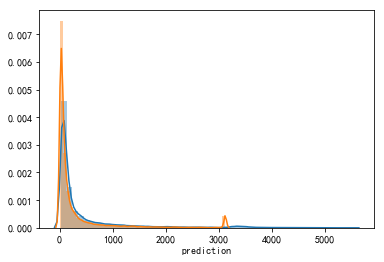

In [628]:
sns.distplot(pred['prediction']);
sns.distplot(y_test_ns);

In [630]:
gbm = lgb.LGBMRegressor(alpha=0.9, objective='quantile', max_depth = -10, num_leaves=31, learning_rate=0.05, 
                        n_estimators=2000, 
                        subsample=0.7,
                        silent=1,
                        seed=0 )

gbm.fit(X_train, y_train.values.T[0], eval_set=(X_test, y_test.values.T[0])) 

[1]	valid_0's l2: 0.0487298
[2]	valid_0's l2: 0.0445554
[3]	valid_0's l2: 0.0407842
[4]	valid_0's l2: 0.0372965
[5]	valid_0's l2: 0.0342835
[6]	valid_0's l2: 0.0315518
[7]	valid_0's l2: 0.0290666
[8]	valid_0's l2: 0.0267909
[9]	valid_0's l2: 0.0247907
[10]	valid_0's l2: 0.0229745
[11]	valid_0's l2: 0.0213495
[12]	valid_0's l2: 0.0198816
[13]	valid_0's l2: 0.0185384
[14]	valid_0's l2: 0.0173339
[15]	valid_0's l2: 0.0162393
[16]	valid_0's l2: 0.015247
[17]	valid_0's l2: 0.0143636
[18]	valid_0's l2: 0.0135632
[19]	valid_0's l2: 0.0128231
[20]	valid_0's l2: 0.0121894
[21]	valid_0's l2: 0.0116021
[22]	valid_0's l2: 0.0110638
[23]	valid_0's l2: 0.0105815
[24]	valid_0's l2: 0.0101518
[25]	valid_0's l2: 0.00974913
[26]	valid_0's l2: 0.00939183
[27]	valid_0's l2: 0.00906935
[28]	valid_0's l2: 0.00878439
[29]	valid_0's l2: 0.00853281
[30]	valid_0's l2: 0.00829641
[31]	valid_0's l2: 0.0080717
[32]	valid_0's l2: 0.00787892
[33]	valid_0's l2: 0.00770543
[34]	valid_0's l2: 0.0075507
[35]	valid_0's l

[281]	valid_0's l2: 0.00615119
[282]	valid_0's l2: 0.00615283
[283]	valid_0's l2: 0.00615587
[284]	valid_0's l2: 0.0061557
[285]	valid_0's l2: 0.00615429
[286]	valid_0's l2: 0.00615339
[287]	valid_0's l2: 0.00615336
[288]	valid_0's l2: 0.00615691
[289]	valid_0's l2: 0.00615614
[290]	valid_0's l2: 0.00615538
[291]	valid_0's l2: 0.00615415
[292]	valid_0's l2: 0.00615484
[293]	valid_0's l2: 0.00615274
[294]	valid_0's l2: 0.00615209
[295]	valid_0's l2: 0.0061551
[296]	valid_0's l2: 0.00615456
[297]	valid_0's l2: 0.00615766
[298]	valid_0's l2: 0.00615669
[299]	valid_0's l2: 0.00615657
[300]	valid_0's l2: 0.00615608
[301]	valid_0's l2: 0.0061557
[302]	valid_0's l2: 0.00615448
[303]	valid_0's l2: 0.0061548
[304]	valid_0's l2: 0.00615353
[305]	valid_0's l2: 0.00615586
[306]	valid_0's l2: 0.00615496
[307]	valid_0's l2: 0.00615288
[308]	valid_0's l2: 0.00615331
[309]	valid_0's l2: 0.00615301
[310]	valid_0's l2: 0.0061553
[311]	valid_0's l2: 0.00615432
[312]	valid_0's l2: 0.00615399
[313]	valid_0

[551]	valid_0's l2: 0.0060479
[552]	valid_0's l2: 0.00604458
[553]	valid_0's l2: 0.00604285
[554]	valid_0's l2: 0.00604074
[555]	valid_0's l2: 0.00604166
[556]	valid_0's l2: 0.00604235
[557]	valid_0's l2: 0.00604367
[558]	valid_0's l2: 0.00604156
[559]	valid_0's l2: 0.00604045
[560]	valid_0's l2: 0.006039
[561]	valid_0's l2: 0.00603769
[562]	valid_0's l2: 0.00603762
[563]	valid_0's l2: 0.00603627
[564]	valid_0's l2: 0.00603128
[565]	valid_0's l2: 0.00603064
[566]	valid_0's l2: 0.00602973
[567]	valid_0's l2: 0.00602812
[568]	valid_0's l2: 0.0060264
[569]	valid_0's l2: 0.00602563
[570]	valid_0's l2: 0.00602331
[571]	valid_0's l2: 0.00602115
[572]	valid_0's l2: 0.00601978
[573]	valid_0's l2: 0.00601913
[574]	valid_0's l2: 0.00601647
[575]	valid_0's l2: 0.00601426
[576]	valid_0's l2: 0.00601339
[577]	valid_0's l2: 0.00601299
[578]	valid_0's l2: 0.00601197
[579]	valid_0's l2: 0.00601152
[580]	valid_0's l2: 0.0060113
[581]	valid_0's l2: 0.00601038
[582]	valid_0's l2: 0.00600943
[583]	valid_0

[834]	valid_0's l2: 0.00583224
[835]	valid_0's l2: 0.0058328
[836]	valid_0's l2: 0.00583174
[837]	valid_0's l2: 0.00583091
[838]	valid_0's l2: 0.00583003
[839]	valid_0's l2: 0.00583023
[840]	valid_0's l2: 0.0058285
[841]	valid_0's l2: 0.00582701
[842]	valid_0's l2: 0.00582719
[843]	valid_0's l2: 0.00582766
[844]	valid_0's l2: 0.00582728
[845]	valid_0's l2: 0.00582749
[846]	valid_0's l2: 0.00582671
[847]	valid_0's l2: 0.00582599
[848]	valid_0's l2: 0.00582497
[849]	valid_0's l2: 0.00582334
[850]	valid_0's l2: 0.00582289
[851]	valid_0's l2: 0.00582204
[852]	valid_0's l2: 0.00582104
[853]	valid_0's l2: 0.0058199
[854]	valid_0's l2: 0.00581837
[855]	valid_0's l2: 0.00581818
[856]	valid_0's l2: 0.00581778
[857]	valid_0's l2: 0.00581627
[858]	valid_0's l2: 0.00581529
[859]	valid_0's l2: 0.00581607
[860]	valid_0's l2: 0.00581518
[861]	valid_0's l2: 0.00581502
[862]	valid_0's l2: 0.00581428
[863]	valid_0's l2: 0.00581326
[864]	valid_0's l2: 0.005813
[865]	valid_0's l2: 0.00581332
[866]	valid_0

[1109]	valid_0's l2: 0.00571595
[1110]	valid_0's l2: 0.00571535
[1111]	valid_0's l2: 0.00571535
[1112]	valid_0's l2: 0.00571453
[1113]	valid_0's l2: 0.005714
[1114]	valid_0's l2: 0.00571414
[1115]	valid_0's l2: 0.00571399
[1116]	valid_0's l2: 0.00571436
[1117]	valid_0's l2: 0.00571379
[1118]	valid_0's l2: 0.00571313
[1119]	valid_0's l2: 0.00571278
[1120]	valid_0's l2: 0.00571197
[1121]	valid_0's l2: 0.0057115
[1122]	valid_0's l2: 0.00571095
[1123]	valid_0's l2: 0.00571138
[1124]	valid_0's l2: 0.00571109
[1125]	valid_0's l2: 0.00571151
[1126]	valid_0's l2: 0.0057108
[1127]	valid_0's l2: 0.0057143
[1128]	valid_0's l2: 0.00571336
[1129]	valid_0's l2: 0.00571265
[1130]	valid_0's l2: 0.00571167
[1131]	valid_0's l2: 0.00571081
[1132]	valid_0's l2: 0.00571105
[1133]	valid_0's l2: 0.00571018
[1134]	valid_0's l2: 0.00570964
[1135]	valid_0's l2: 0.00570902
[1136]	valid_0's l2: 0.00570763
[1137]	valid_0's l2: 0.00570712
[1138]	valid_0's l2: 0.00570619
[1139]	valid_0's l2: 0.0057064
[1140]	valid_0

[1378]	valid_0's l2: 0.00561321
[1379]	valid_0's l2: 0.00561293
[1380]	valid_0's l2: 0.00561187
[1381]	valid_0's l2: 0.00561248
[1382]	valid_0's l2: 0.00561412
[1383]	valid_0's l2: 0.00561385
[1384]	valid_0's l2: 0.00561336
[1385]	valid_0's l2: 0.00561319
[1386]	valid_0's l2: 0.00561257
[1387]	valid_0's l2: 0.00561209
[1388]	valid_0's l2: 0.0056122
[1389]	valid_0's l2: 0.00561184
[1390]	valid_0's l2: 0.00561402
[1391]	valid_0's l2: 0.00561356
[1392]	valid_0's l2: 0.00561316
[1393]	valid_0's l2: 0.00561217
[1394]	valid_0's l2: 0.00561173
[1395]	valid_0's l2: 0.00561083
[1396]	valid_0's l2: 0.00560904
[1397]	valid_0's l2: 0.00560844
[1398]	valid_0's l2: 0.0056078
[1399]	valid_0's l2: 0.00560776
[1400]	valid_0's l2: 0.00560758
[1401]	valid_0's l2: 0.00560658
[1402]	valid_0's l2: 0.00560602
[1403]	valid_0's l2: 0.00560533
[1404]	valid_0's l2: 0.00560475
[1405]	valid_0's l2: 0.00560424
[1406]	valid_0's l2: 0.00560342
[1407]	valid_0's l2: 0.00560277
[1408]	valid_0's l2: 0.00560267
[1409]	val

[1646]	valid_0's l2: 0.00553746
[1647]	valid_0's l2: 0.00553719
[1648]	valid_0's l2: 0.00553703
[1649]	valid_0's l2: 0.00553714
[1650]	valid_0's l2: 0.00553708
[1651]	valid_0's l2: 0.00553676
[1652]	valid_0's l2: 0.00553649
[1653]	valid_0's l2: 0.00553639
[1654]	valid_0's l2: 0.00553621
[1655]	valid_0's l2: 0.005536
[1656]	valid_0's l2: 0.0055356
[1657]	valid_0's l2: 0.00553556
[1658]	valid_0's l2: 0.00553536
[1659]	valid_0's l2: 0.00553519
[1660]	valid_0's l2: 0.00553494
[1661]	valid_0's l2: 0.00553499
[1662]	valid_0's l2: 0.00553612
[1663]	valid_0's l2: 0.00553599
[1664]	valid_0's l2: 0.00553605
[1665]	valid_0's l2: 0.00553609
[1666]	valid_0's l2: 0.00553608
[1667]	valid_0's l2: 0.00553579
[1668]	valid_0's l2: 0.0055355
[1669]	valid_0's l2: 0.00553534
[1670]	valid_0's l2: 0.00553528
[1671]	valid_0's l2: 0.00553505
[1672]	valid_0's l2: 0.00553494
[1673]	valid_0's l2: 0.00553486
[1674]	valid_0's l2: 0.0055345
[1675]	valid_0's l2: 0.00553405
[1676]	valid_0's l2: 0.00553389
[1677]	valid_

[1911]	valid_0's l2: 0.00549332
[1912]	valid_0's l2: 0.00549294
[1913]	valid_0's l2: 0.00549256
[1914]	valid_0's l2: 0.0054921
[1915]	valid_0's l2: 0.00549177
[1916]	valid_0's l2: 0.00549102
[1917]	valid_0's l2: 0.00549078
[1918]	valid_0's l2: 0.00549122
[1919]	valid_0's l2: 0.00549154
[1920]	valid_0's l2: 0.00549117
[1921]	valid_0's l2: 0.00549074
[1922]	valid_0's l2: 0.00549056
[1923]	valid_0's l2: 0.00549024
[1924]	valid_0's l2: 0.00549082
[1925]	valid_0's l2: 0.00549209
[1926]	valid_0's l2: 0.00549195
[1927]	valid_0's l2: 0.00549204
[1928]	valid_0's l2: 0.00549131
[1929]	valid_0's l2: 0.0054909
[1930]	valid_0's l2: 0.00549058
[1931]	valid_0's l2: 0.00549041
[1932]	valid_0's l2: 0.00549021
[1933]	valid_0's l2: 0.00549002
[1934]	valid_0's l2: 0.00548967
[1935]	valid_0's l2: 0.00548931
[1936]	valid_0's l2: 0.00548895
[1937]	valid_0's l2: 0.0054889
[1938]	valid_0's l2: 0.00548864
[1939]	valid_0's l2: 0.00548848
[1940]	valid_0's l2: 0.0054881
[1941]	valid_0's l2: 0.00548808
[1942]	valid

LGBMRegressor(alpha=0.9, boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, learning_rate=0.05, max_depth=-10,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=2000, n_jobs=-1, num_leaves=31, objective='quantile',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=0, silent=1,
       subsample=0.7, subsample_for_bin=200000, subsample_freq=0)

In [631]:
gbm_pred=gbm.predict(X_test) 

In [632]:
gbm_pred = pd.DataFrame(y_scaler.inverse_transform(gbm_pred.reshape(-1, 1)), columns=['prediction']).fillna(0)
# gbm_pred = pd.DataFrame(gbm_pred.reshape(-1, 1), columns=['prediction']).fillna(0)

In [633]:
h = 1
b = 9

In [634]:
o4 = df_test.copy()
o4.reset_index(drop=True, inplace=True)


In [635]:
o4['actual_pur_qtty'];
o4['overall_opt_order_for_opt'];

In [636]:
o4['demand_RV_list'] = o4.apply(lambda x: df_sl.loc[x['item_sku_id'], \
                                            x['create_tm'].date():x['next_complete_dt'].date()].values\
                            if x['item_sku_id'] in df_sl.index else [], axis=1)

In [637]:
o4['demand_RV_list_acm'] = o4['demand_RV_list'].apply(lambda x: np.cumsum(x))

In [781]:
list_c = ['SKU_DC', 'create_tm', 'OPT', 'E2E_NN', 'E2E_GBM', 'EQ',  'Normal', 'Gamma', 'Hist', 
          'Ave_sales','Std_sales', 
#           'Ave_review', 'Std_review'
         ]
numberOfRows = len(o4)

df_cost = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_holding = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_back = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_stockout = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_turnover = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)

In [782]:
df_cost['SKU_DC']=df_holding['SKU_DC']=df_back['SKU_DC']=df_stockout['SKU_DC']=df_turnover['SKU_DC']=o4['item_sku_id'].values
df_cost['create_tm']=df_holding['create_tm']=df_back['create_tm']=df_stockout['create_tm']=df_turnover['create_tm']=o4['create_tm'].values
df_cost['Ave_sales']=df_holding['Ave_sales']=df_back['Ave_sales']=df_stockout['Ave_sales']=df_turnover['Ave_sales']=o4['mean_112'].values
df_cost['Std_sales']=df_holding['Std_sales']=df_back['Std_sales']=df_stockout['Std_sales']=df_turnover['Std_sales']=o4['std_140'].values

In [803]:
def get_inv(x, name):
    inv = []
    if name == 'actual_pur_qtty':
        for t in range(len(x['demand_RV_list_acm'])):
            if t < np.ceil(x['vlt_actual']):
                inv.append(x['initial_stock']-x['demand_RV_list_acm'][t])
            elif t == np.ceil(x['vlt_actual']):
                inv_bk = x['initial_stock']-x['demand_RV_list_acm'][t]
                real_inv = inv_bk+x[name] if inv_bk > 0 else x[name]
                inv.append(real_inv)
            else:
#                 if inv[-1] <= 0:
#                     inv.append(-x['demand_RV_list'][t])
#                 else:
                inv.append(inv[-1] - x['demand_RV_list'][t])
        return inv
    for t in range(len(x['demand_RV_list_acm'])):
        if t < np.ceil(x['vlt_actual']):
            inv.append(x['initial_stock']-x['demand_RV_list_acm'][t])
        else:
#             if inv[-1] <= 0:
#                 inv.append(-x['demand_RV_list'][t])
#             else:
#                 inv.append(inv[-1] - x['demand_RV_list'][t])
            inv.append(x[name]+x['initial_stock']-x['demand_RV_list_acm'][t])
    return inv
    
    
o4['OPT_inv'] = o4.apply(get_inv, name='target_decision', axis=1)

o4['nn_pred'] = (pred['prediction'] - o4['initial_stock'])
o4['E2E_NN_inv'] = o4.apply(get_inv, name='nn_pred', axis=1)

o4['EQ_replen'] = pd.read_csv('EQ_replen_with_IS.csv')
o4['EQ_replen'] = (o4['EQ_replen'] - o4['initial_stock']).clip(0)
o4['EQ_inv'] = o4.apply(get_inv, name='EQ_replen', axis=1)

o4['Normal_replen'] = o4.apply(lambda x: int(x['mean_112']*(x['review_period']+x['vendor_vlt_mean'])
                                       +Z90*np.sqrt((x['review_period']+x['vendor_vlt_mean'])*x['std_140']**2
                                                    + x['std_140']**2 * x['vlt_std'])), axis=1)
o4['Normal_replen'] = (o4['Normal_replen'] - o4['initial_stock']).clip(0)
o4['Normal_inv'] = o4.apply(get_inv, name='Normal_replen',  axis=1)

def gamma_base(x):
    mean = x['mean_112']
    var = x['std_140']**2
    theta = var/(mean+1e-5)
    k = mean/(theta+1e-5)
    k_sum = int(x['review_period']+x['vendor_vlt_mean'])*k
    gamma_stock = gamma.ppf(0.9, a=k_sum, scale = theta)
    if(np.isnan(gamma_stock)):
        return 0
    else:
        return int(gamma_stock)

o4['Gamma_replen'] = o4.apply(gamma_base, axis=1)
o4['Gamma_replen'] = (o4['Gamma_replen'] - o4['initial_stock']).clip(0)
o4['Gamma_inv'] = o4.apply(get_inv, name='Gamma_replen', axis=1)

o4['Hist_inv'] = o4.apply(get_inv, name='actual_pur_qtty', axis=1)

o4['gbm_pred'] = (gbm_pred['prediction'] - o4['initial_stock']).clip(0)
o4['E2E_GBM_inv'] = o4.apply(get_inv, name='gbm_pred',  axis=1)


In [804]:
# o4['demand_EQ_list'] = o4.apply(lambda x: df_sl.iloc[:,360:].loc[x['item_sku_id'], \
#                                             :x['create_tm'].date()].values\
#                             if x['item_sku_id'] in df_sl.index else [], axis=1)
# o4['EQ_replen_with_IS'] = o4.apply(lambda x: np.percentile(
#                             [np.sum(x['demand_EQ_list'][i:i+int(x['review_period']+x['vendor_vlt_mean'])])
#                                      for i in range(int(len(x['demand_EQ_list'])-x['review_period']-x['vendor_vlt_mean']))
#                             ], 90), axis=1)
# o4['EQ_replen_with_IS'] = o4['EQ_replen_with_IS'] - o4['initial_stock_overall']
# o4['EQ_replen_with_IS'].to_csv('EQ_replen_with_IS.csv', index=False)
# o4['EQ_replen_with_IS'] = pd.read_csv('EQ_replen_with_IS.csv')


In [805]:
str_list = ['OPT', 'E2E_NN', 'E2E_GBM', 'EQ', 'Normal', 'Gamma', 'Hist']
for str1 in str_list:
    str2 = str1 + '_inv'
    df_holding[str1] = o4[str2].apply(lambda x: h * sum([inv for inv in x if inv>0]) )
    df_back[str1] = o4[str2].apply(lambda x: b * sum([-inv for inv in x if inv<0]) )
    df_stockout[str1] = o4[str2].apply(lambda x: len([inv for inv in x if inv<0])/len(x) )
    df_turnover[str1] = o4.apply(lambda x: np.mean(x[str2]) / np.mean(x['demand_RV_list'])
                                  if np.mean(x['demand_RV_list']) >0 else np.mean(x[str2]), axis=1)
    df_cost[str1] = df_holding[str1] + df_back[str1]

In [806]:
pd.DataFrame({'Best': df_cost.iloc[:,3:9].idxmin(axis=1).value_counts()/len(df_cost)}).T

,Hist,E2E_NN,E2E_GBM,EQ,Gamma,Normal
Best,0.274885,0.224542,0.162328,0.139244,0.119352,0.07965


In [807]:
pd.DataFrame({'Total': df_cost[['OPT','E2E_NN','E2E_GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Holding': df_holding[['OPT','E2E_NN','E2E_GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Back': df_back[['OPT','E2E_NN','E2E_GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Stockout': df_stockout[['OPT','E2E_NN','E2E_GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Turnover': df_turnover[['OPT','E2E_NN','E2E_GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             }).T

,OPT,E2E_NN,E2E_GBM,EQ,Normal,Gamma,Hist,Ave_sales
Total,4258.630976,7443.651267,6288.236467,8552.869237,6458.018664,6461.370580,5958.686067,24.441725
Holding,2661.064669,2924.098163,2969.113697,4287.334561,3517.998035,3440.153242,3126.988130,24.441725
Back,1597.566306,4519.553105,3319.122770,4265.534676,2940.020629,3021.217338,2831.697937,24.441725
Stockout,0.197425,0.224923,0.228420,0.282472,0.243980,0.249950,0.258696,24.441725
Turnover,6.264873,27.302104,14.416035,73.196197,15.560217,15.107159,11.933405,24.441725


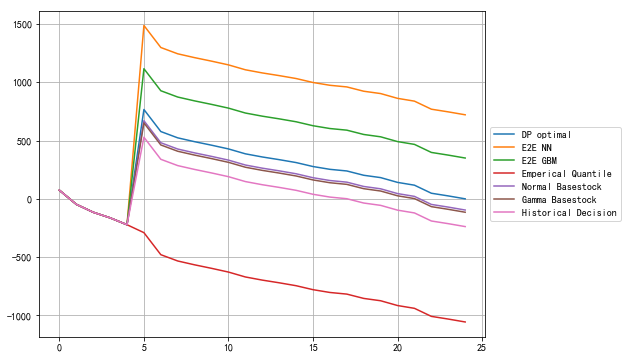

In [814]:
tt = o4.iloc[300,:]
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(tt['OPT_inv'], label = 'DP optimal')
ax1.plot(tt['E2E_NN_inv'], label = 'E2E NN')
ax1.plot(tt['E2E_GBM_inv'], label = 'E2E GBM')
ax1.plot(tt['EQ_inv'], label = 'Emperical Quantile')
ax1.plot(tt['Normal_inv'], label = 'Normal Basestock')
ax1.plot(tt['Gamma_inv'], label = 'Gamma Basestock')
ax1.plot(tt['Hist_inv'], label = 'Historical Decision')
ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax1.grid(True)

In [704]:
co_qtl = df_cost.iloc[:,2:].quantile(np.linspace(0, 1, 11), numeric_only=False)
hd_qtl = df_holding.iloc[:,2:].quantile(np.linspace(0, 1, 11), numeric_only=False)
bk_qtl = df_back.iloc[:,2:].quantile(np.linspace(0, 1, 11), numeric_only=False)

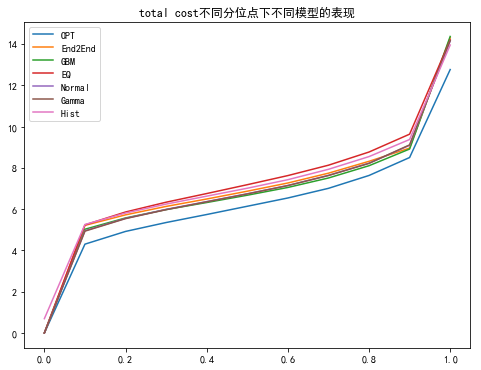

In [705]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.log(co_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.legend(co_qtl.columns[:-2], loc=0)
ax.set_title('total cost不同分位点下不同模型的表现');

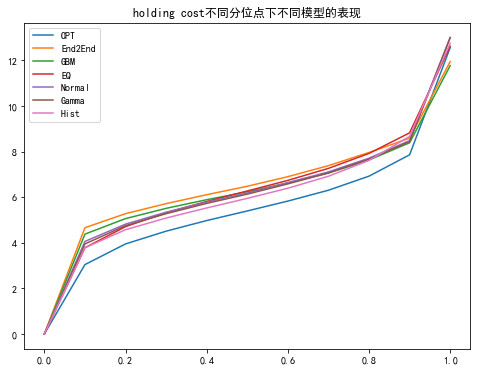

In [706]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.log(hd_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.legend(hd_qtl.columns[:-2], loc=0)
ax.set_title('holding cost不同分位点下不同模型的表现');

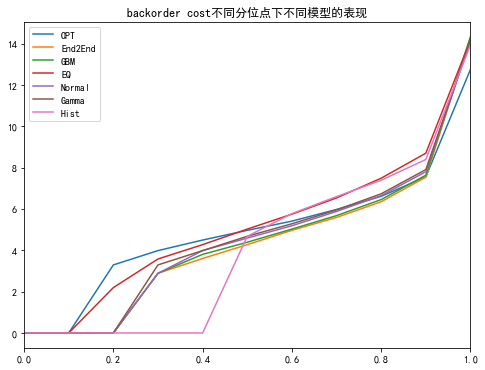

In [707]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.log(bk_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.set_xlim(0, 1)
ax.legend(bk_qtl.columns[:-2], loc=0)
ax.set_title('backorder cost不同分位点下不同模型的表现');

In [ ]:
sess.close()